In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
import cftime
from dask import optimize
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_14744/3290393657.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [3]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [4]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_prw_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'prw' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_prw_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_prw_his = xr.open_zarr(mapper_his, consolidated=True)
display(ds_prw_his)


# date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
# ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
# # weighted product
# tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# # convert to np array
# array_tas_ts = np.array(tas_timeseries_his)
# # plt.plot(array_tas_ts)
# # plt.show()
# year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
# # plt.plot(year_tas_ts)
# # plt.show()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/prw/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    prw        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            prw
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/8e2bf5bf-2173-4813-92b0-c53c5589979c...
    version_id:             v20190514

In [5]:
time = np.arange(1850, 2015, 1/12)
time_in_year = np.arange(1850, 2015, 1)

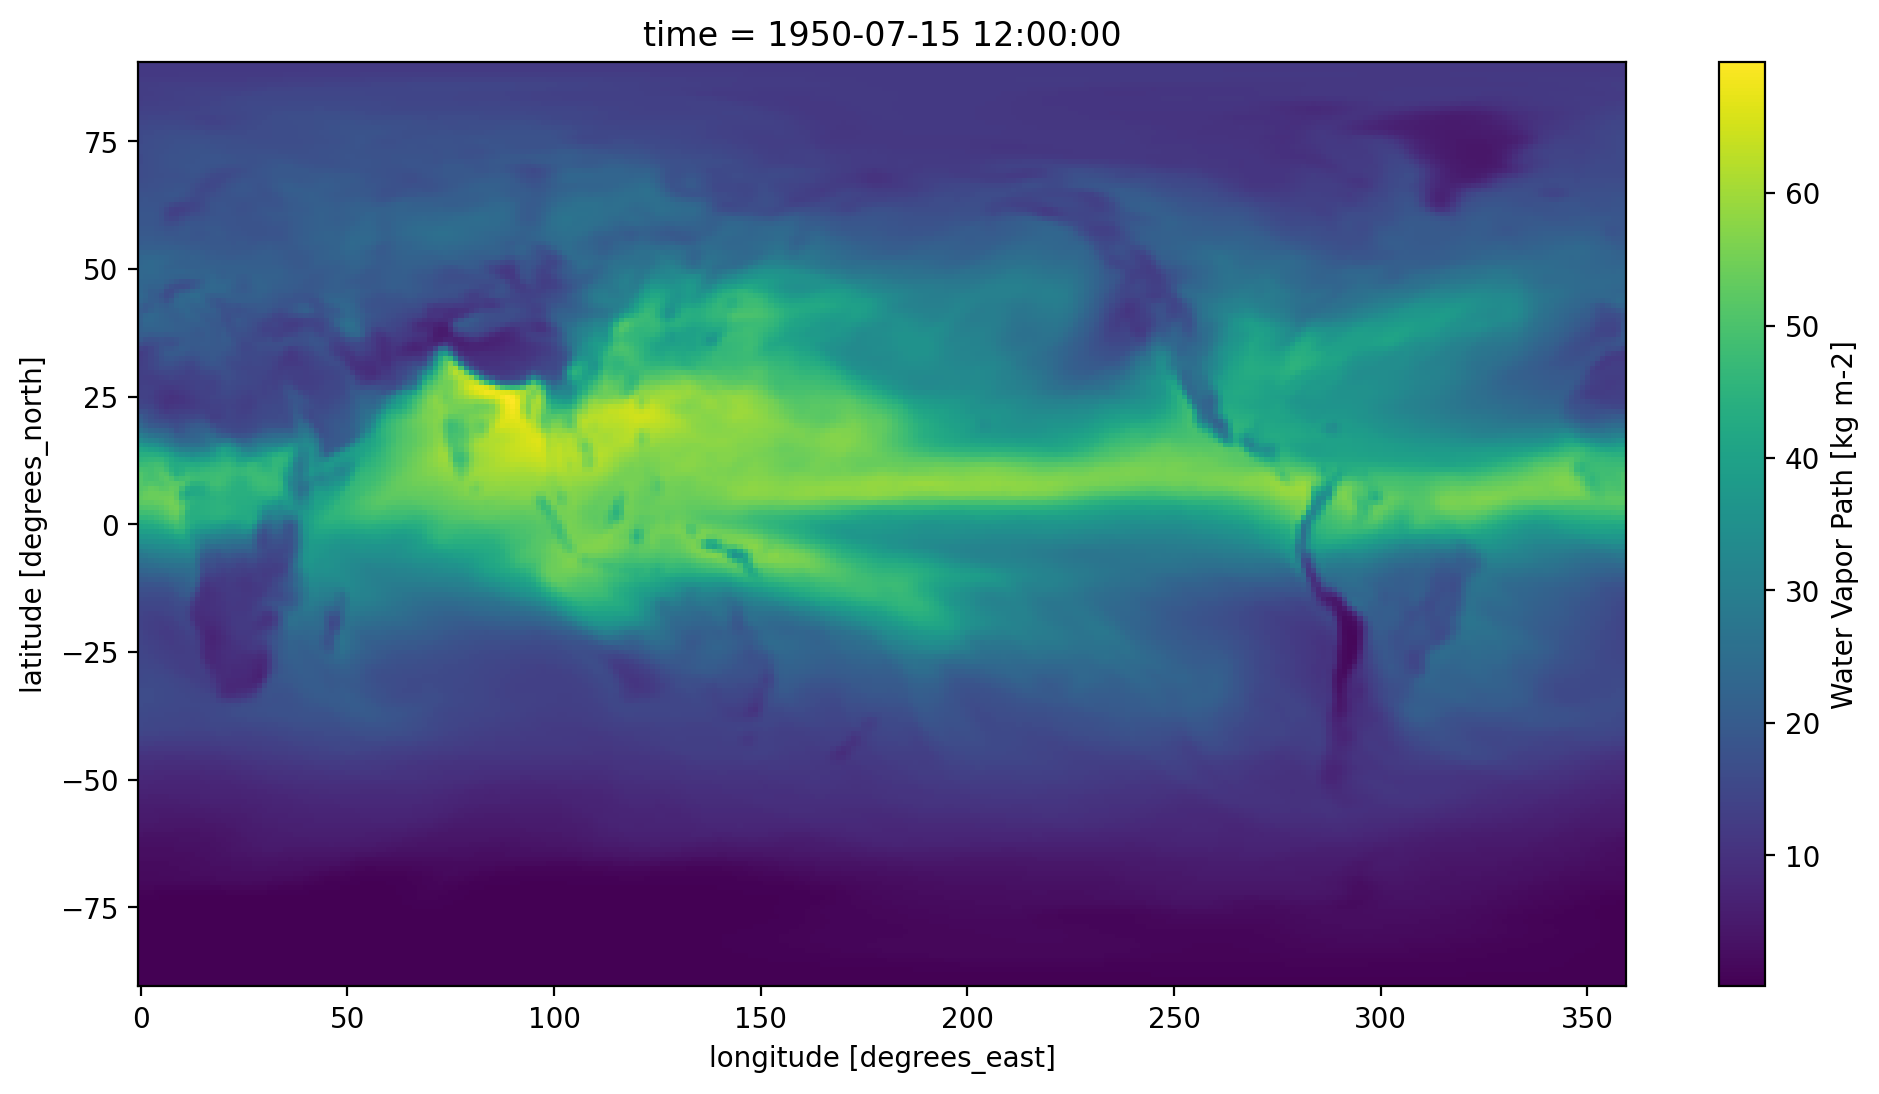

In [6]:
ds_prw_his.prw.sel(time='1950-07').squeeze().plot()

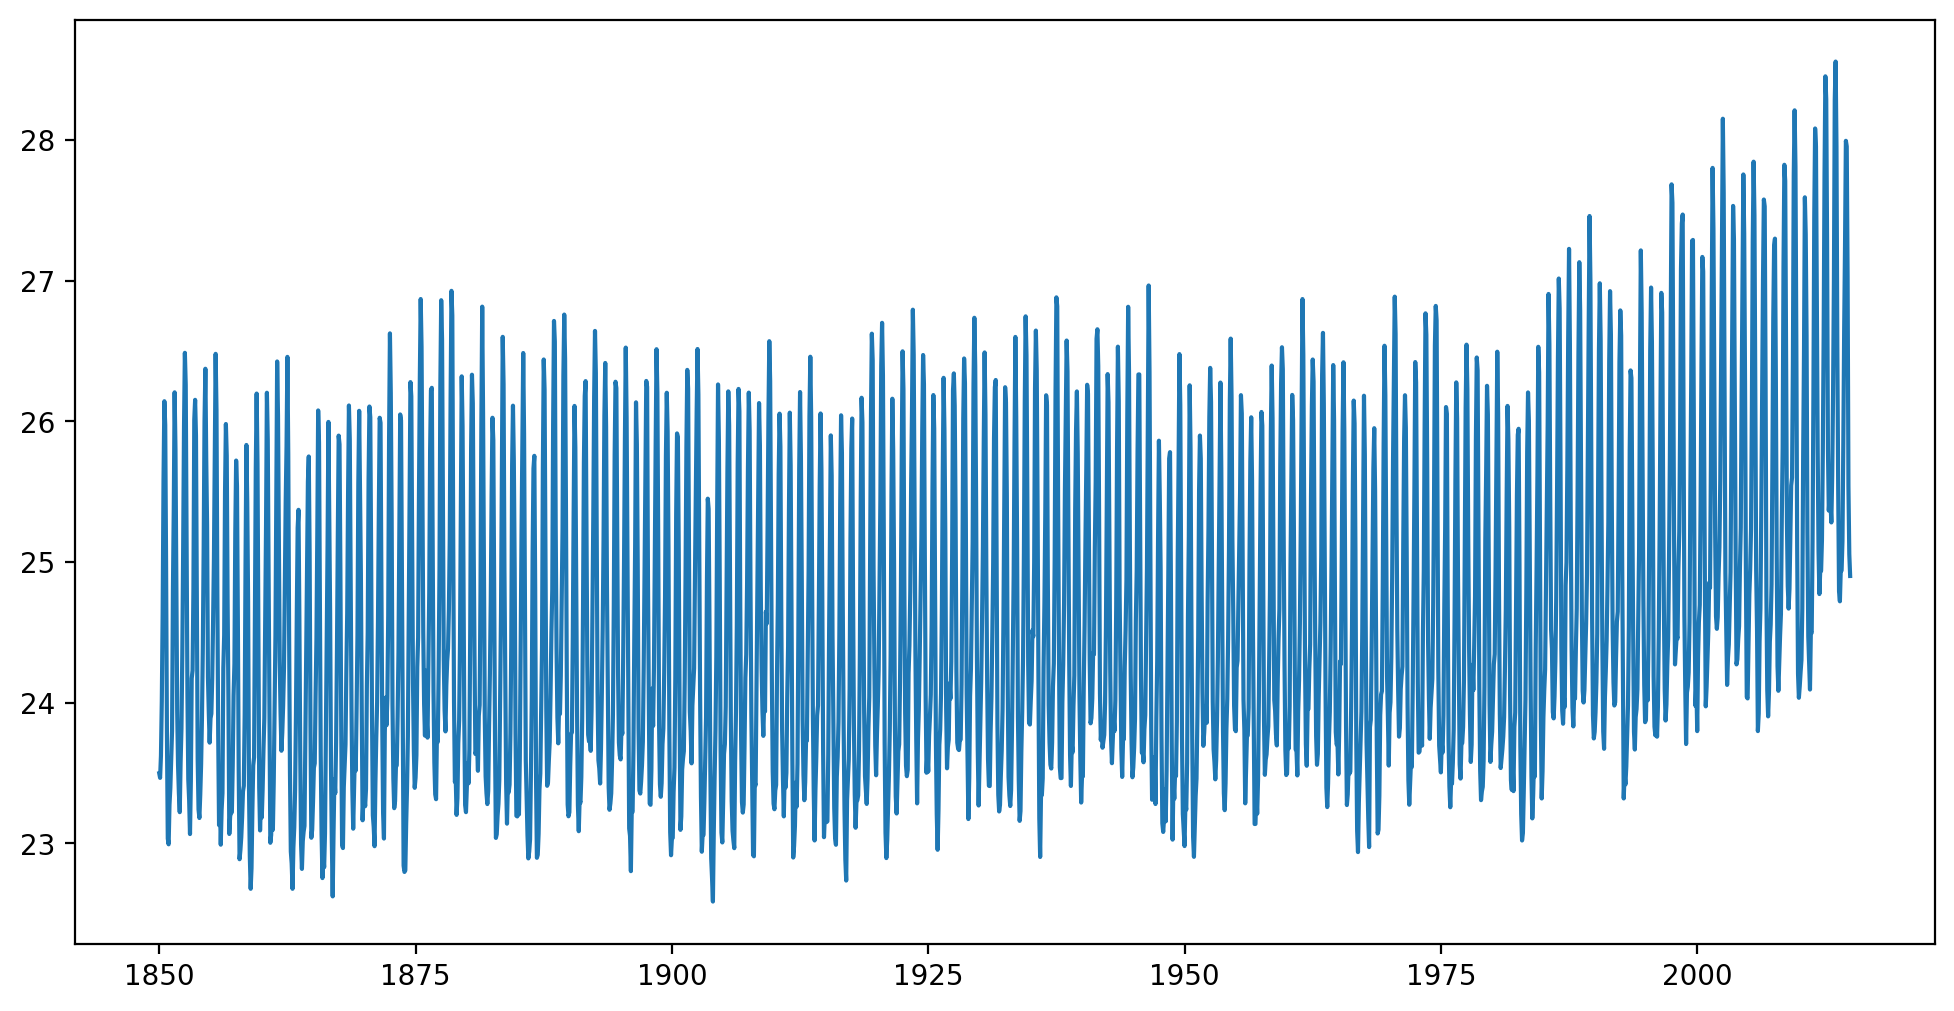

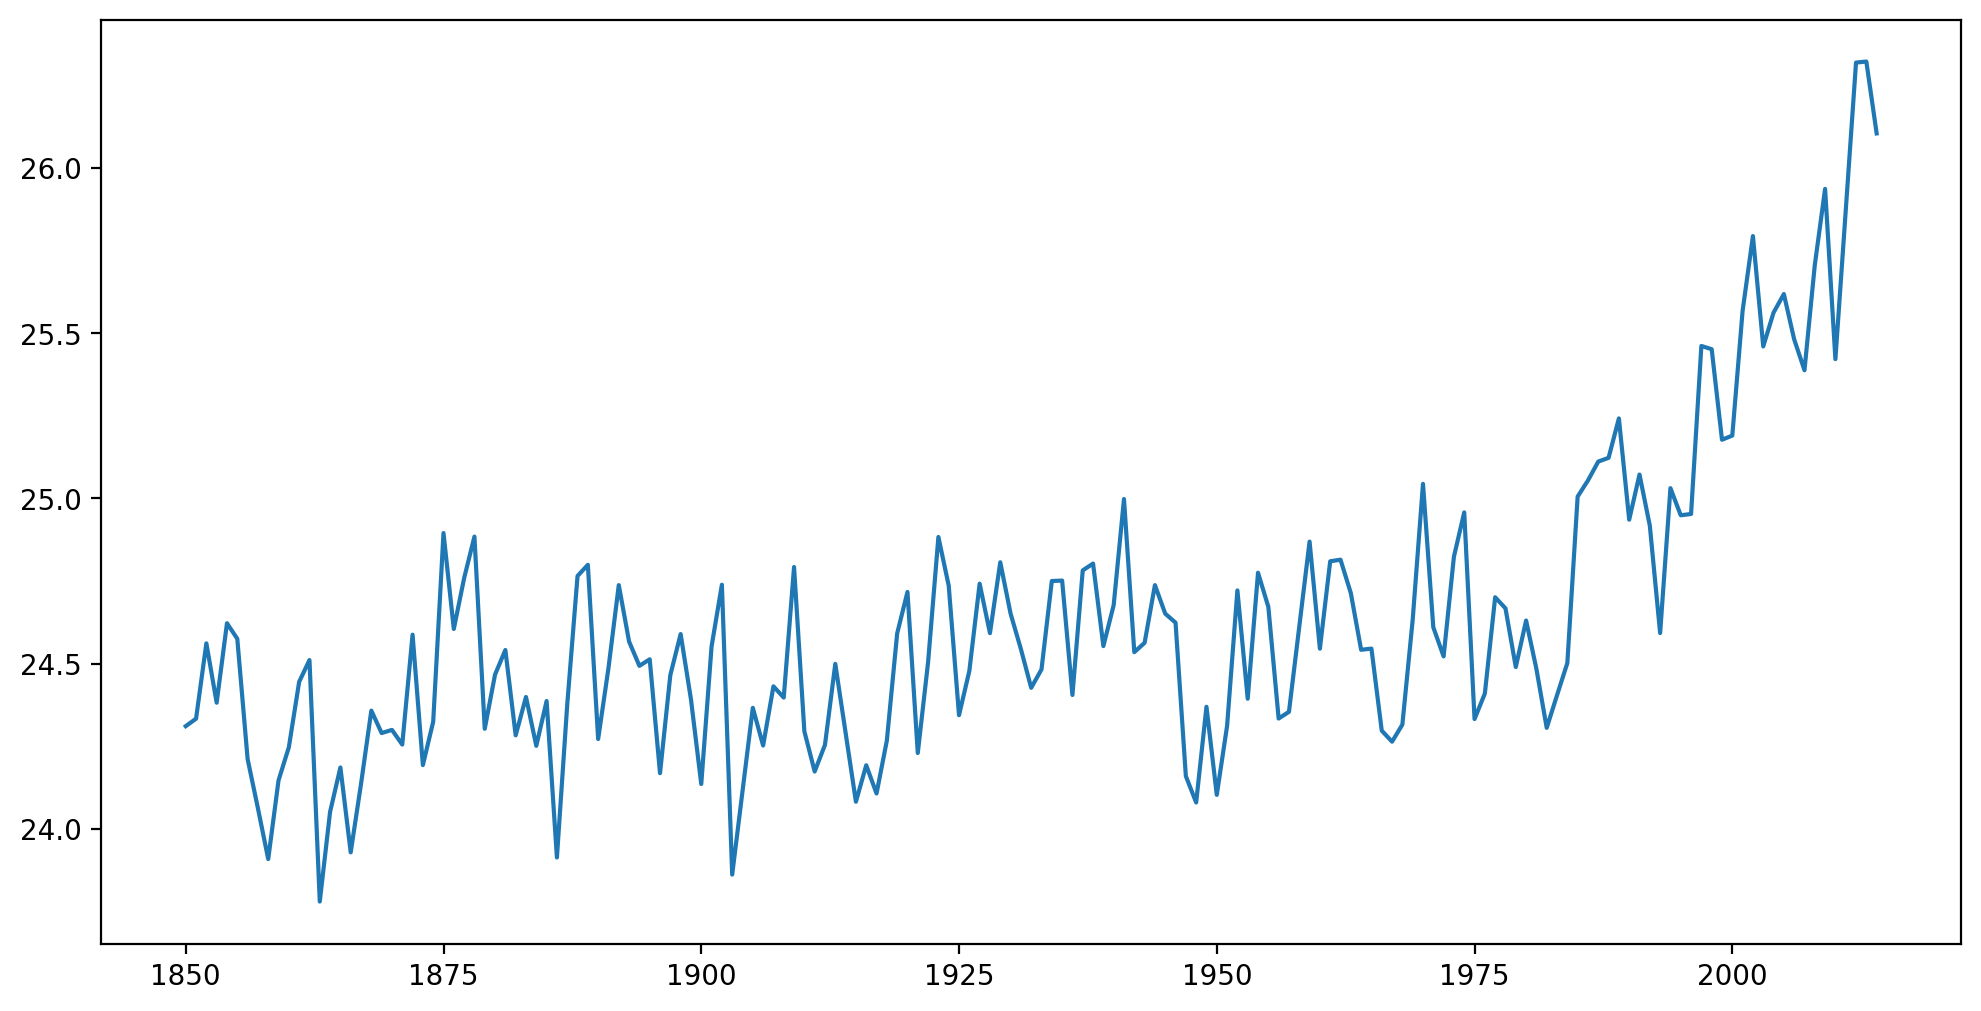

In [7]:
date_threshold = cftime.DatetimeNoLeap(1, 1, 1)
ds_prw_his_plt = ds_prw_his.where(ds_prw_his.time > date_threshold, drop=True)
prw_timeseries_his = (ds_prw_his_plt.prw * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
array_prw_ts = np.array(prw_timeseries_his)
plt.plot(time, array_prw_ts)
plt.show()
year_tas_ts = np.mean(array_prw_ts.reshape(len(array_prw_ts) // 12, 12), axis=1)
plt.plot(time_in_year, year_tas_ts)
plt.show()

In [8]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)
# display(ds_tas_his)

date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
# weighted product
tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# convert to np array
array_tas_ts = np.array(tas_timeseries_his)
# plt.plot(array_tas_ts)
# plt.show()
year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
# plt.plot(year_tas_ts)
# plt.show()


gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/


### Want to estimate $TPW \propto \exp(\alpha + \beta * \Delta T)$. This is the simplified Clausius-Clapeyron formula in Marshall & Plumb

beta: 0.03353654965758324


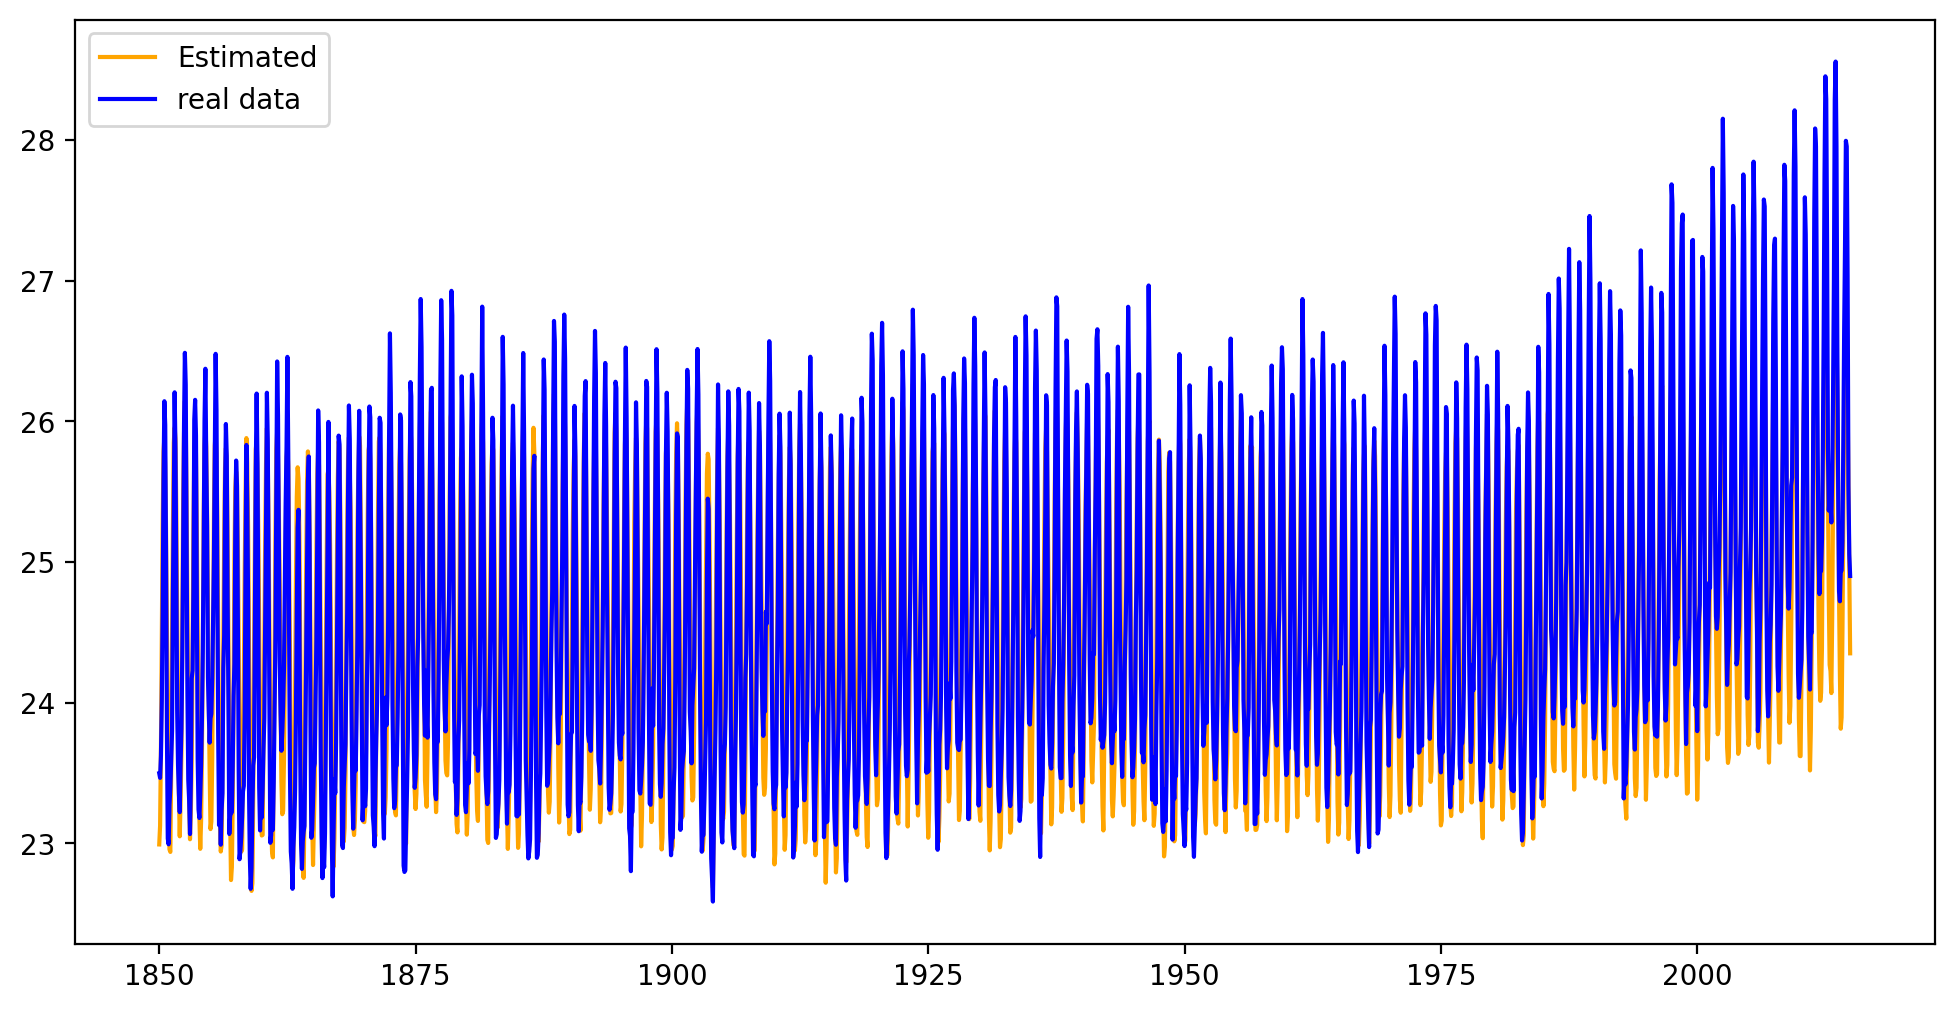

In [9]:
ln_TPW = np.log(array_prw_ts)
X_tas_ts = array_tas_ts.reshape(-1, 1)
LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)
beta, alpha = LR_model.coef_[0] , LR_model.intercept_ 
print(f"beta: {beta}")

estimated_TPW_ts = np.exp(alpha + beta * array_tas_ts)
plt.plot(time, estimated_TPW_ts, label="Estimated", color="orange")
plt.plot(time, array_prw_ts, label="real data", color="blue")
plt.legend()
plt.show()

## Local LR for 1850 - 1985

## The alpha and beta in the output are in this formula: $TPW = \exp(\alpha) \cdot \exp(\beta T)$

beta: 0.03173908218741417


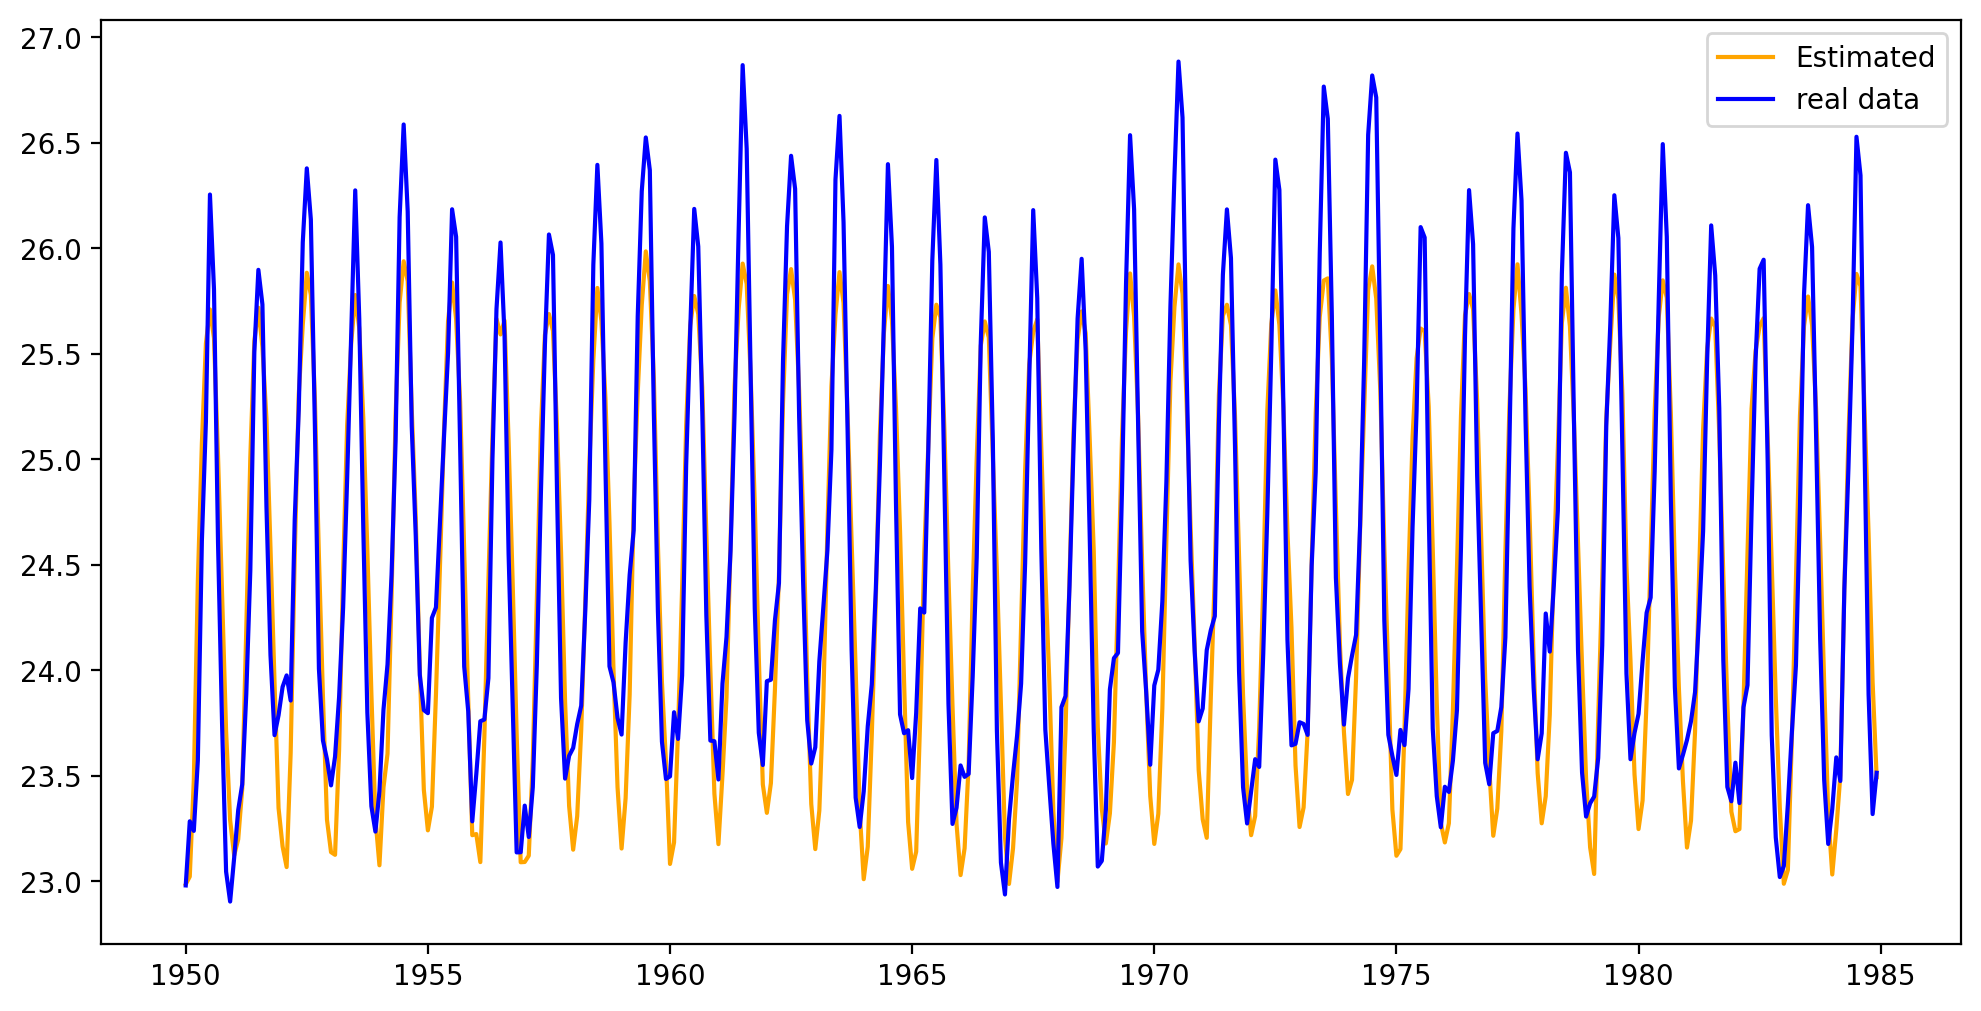

In [10]:
# 1850 - 1985
year_left, year_right  = 1850, 1985
i_left, i_right = (year_left - 1850) * 12, (year_right - 1850) * 12
ln_TPW = np.log(array_prw_ts[i_left: i_right])
X_tas_ts = array_tas_ts[i_left: i_right].reshape(-1, 1)
LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)
beta, alpha = LR_model.coef_[0] , LR_model.intercept_ 
print(f"beta: {beta}")

estimated_TPW_ts = np.exp(alpha + beta * array_tas_ts)
plot_year_left, plot_year_right  = 1950, 1985
plot_i_left, plot_i_right = (plot_year_left - 1850) * 12, (plot_year_right - 1850) * 12
plt.plot(time[plot_i_left: plot_i_right], estimated_TPW_ts[plot_i_left: plot_i_right], label="Estimated", color="orange")
plt.plot(time[plot_i_left: plot_i_right], array_prw_ts[plot_i_left: plot_i_right], label="real data", color="blue")
plt.legend()
plt.show()

## Local LR for 1995 - 2014

beta: 0.037031758576631546


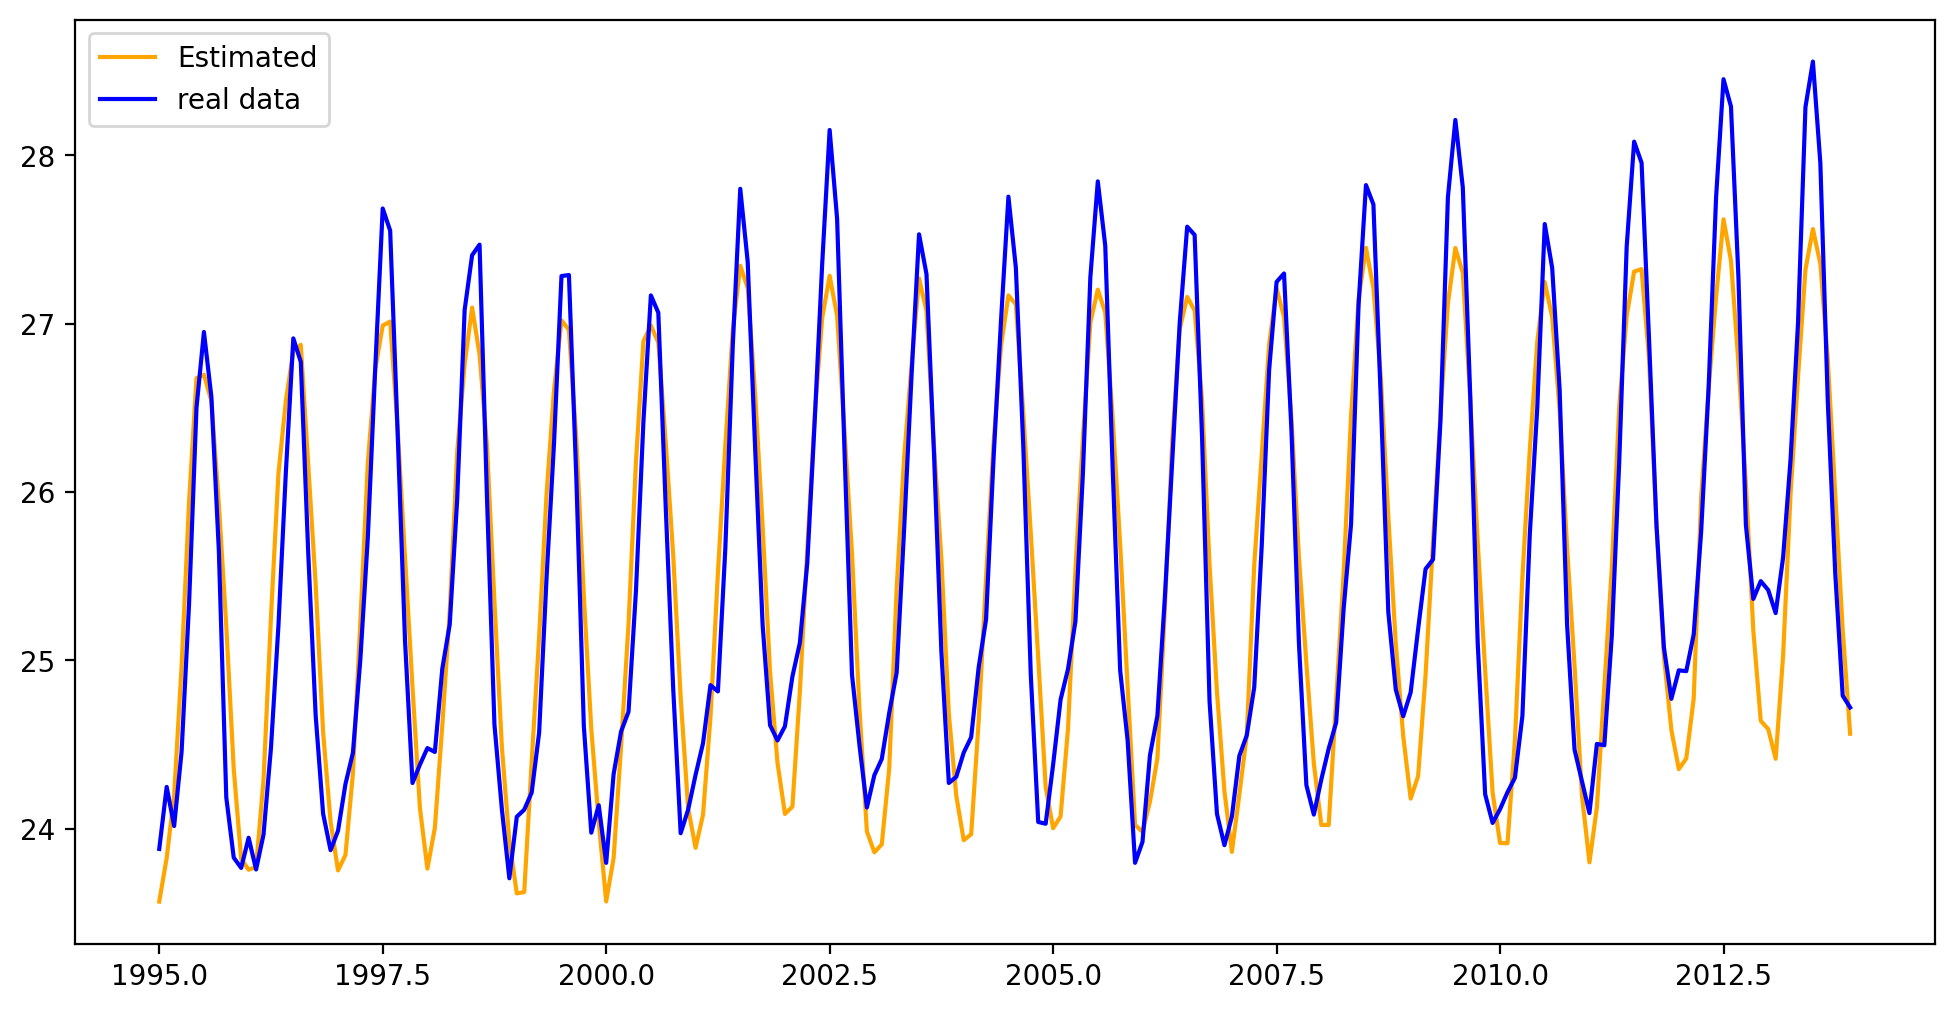

In [ ]:
# 1995 - 2014
year_left, year_right  = 1995, 2014
i_left, i_right = (year_left - 1850) * 12, (year_right - 1850) * 12
ln_TPW = np.log(array_prw_ts[i_left: i_right])
X_tas_ts = array_tas_ts[i_left: i_right].reshape(-1, 1)
LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)
beta, alpha = LR_model.coef_[0] , LR_model.intercept_ 
print(f"beta: {beta}")

estimated_TPW_ts = np.exp(alpha + beta * array_tas_ts)
plot_year_left, plot_year_right  = 1995, 2014
plot_i_left, plot_i_right = (plot_year_left - 1850) * 12, (plot_year_right - 1850) * 12
plt.plot(time[plot_i_left: plot_i_right], estimated_TPW_ts[plot_i_left: plot_i_right], label="Estimated", color="orange")
plt.plot(time[plot_i_left: plot_i_right], array_prw_ts[plot_i_left: plot_i_right], label="real data", color="blue")
plt.legend()
plt.show()

## Local View

In [12]:
# year_left, year_right  = 1900, 1985
# i_left, i_right = (year_left - 1850) * 12, (year_right - 1850) * 12
# plt.plot(time[i_left: i_right], estimated_TPW_ts[i_left: i_right], label="Estimated", color="orange")
# plt.plot(time[i_left: i_right], array_prw_ts[i_left: i_right], label="real data", color="blue")
# plt.legend()
# plt.show()

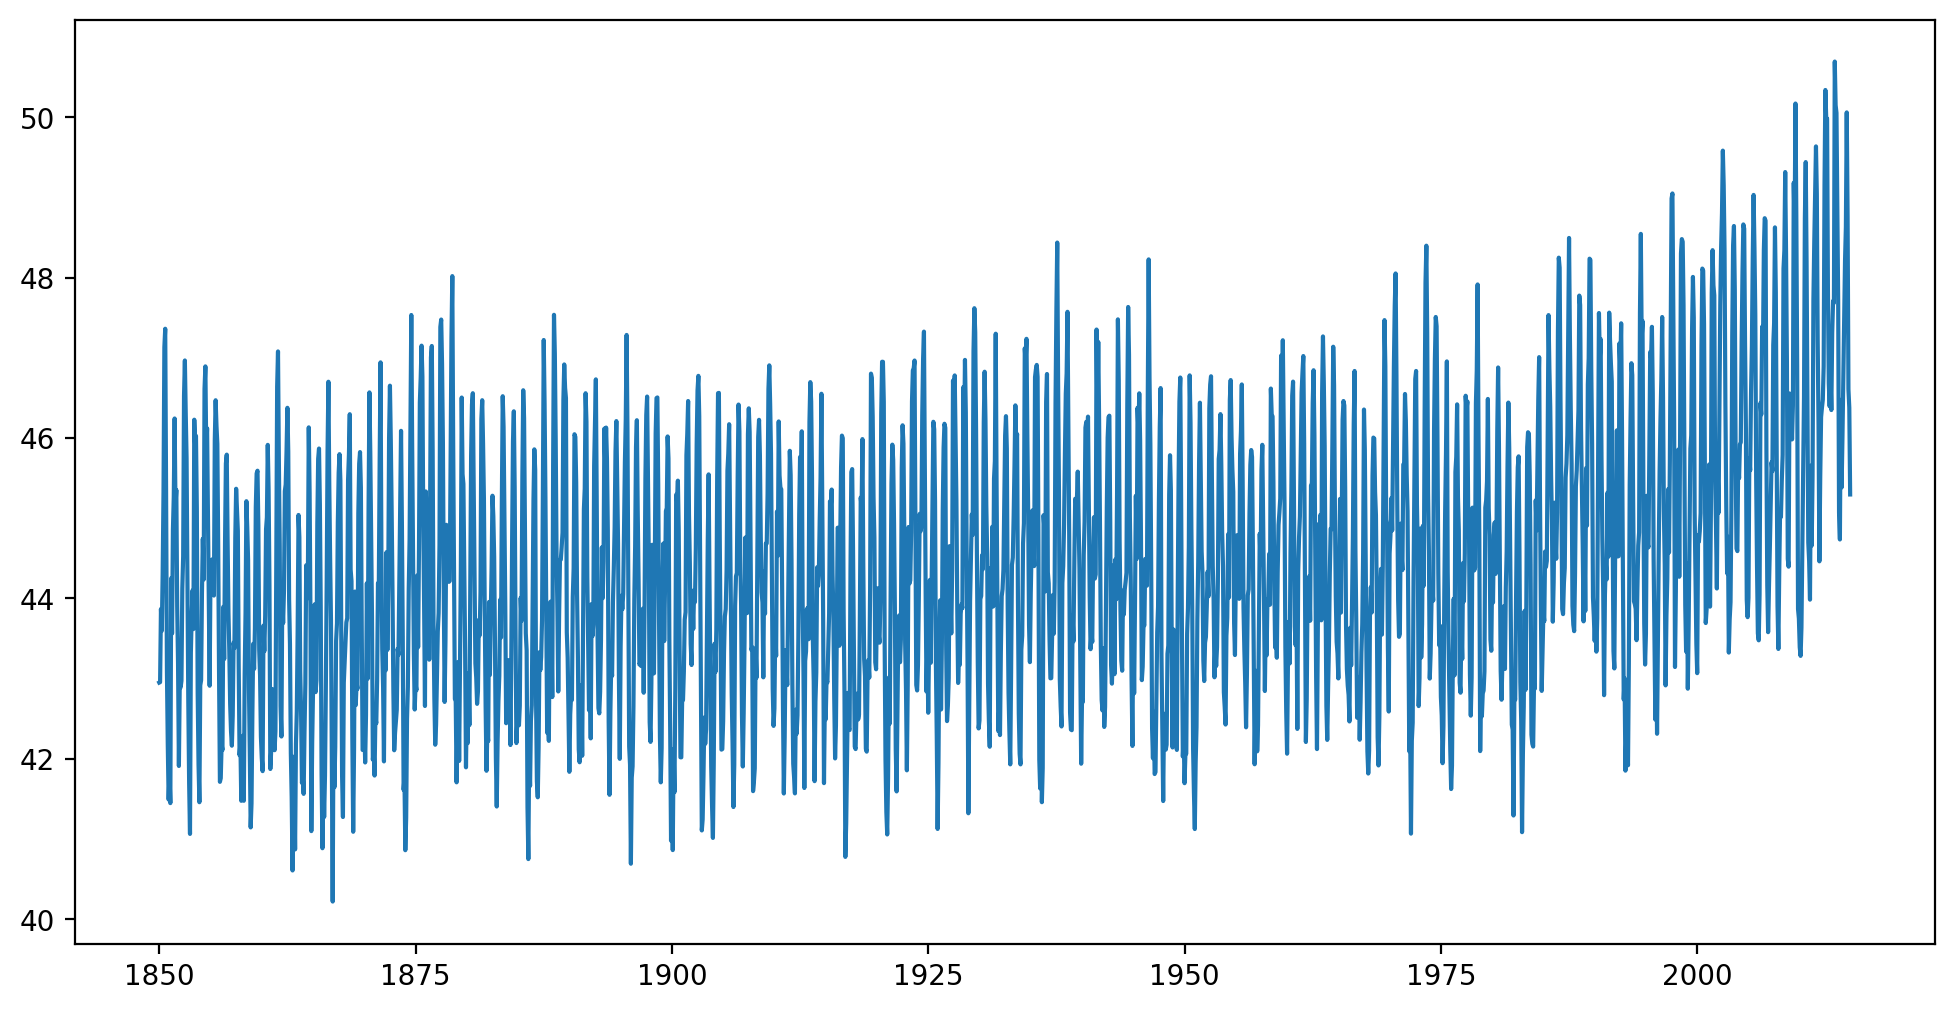

In [13]:
perc_90 = ds_prw_his_plt.quantile(0.90, dim=["lat", "lon"])
array_prw_90 = perc_90.prw.values
plt.plot(time, array_prw_90)
plt.show()

In [14]:
perc_90.prw.values

array([42.94988632, 42.95516586, 43.86786461, ..., 46.60687828,
       46.37676239, 45.29550552])

In [15]:
# Extract PRW as a DataArray from the dataset
prw_da = ds_prw_his["prw"]

# Compute the 90th percentile over lat/lon for each time step
perc_90_prw = prw_da.quantile(0.90, dim=["lat", "lon"]).compute()  # Compute to ensure NumPy operations work

# Compute full dataset values before NumPy operations
prw_values = prw_da.compute().values  # Convert Dask array to NumPy
lat_values = prw_da.lat.values
lon_values = prw_da.lon.values
time_values = prw_da.time.values


In [ ]:
# Initialize storage for lat/lon indices
lat_90_idx = []
lon_90_idx = []

# Iterate over each time step to find the location of the 90th percentile value
for t in range(len(time_values)):
    prw_at_t = prw_values[t, :, :]  # Extract 2D array for current time step
    threshold = perc_90_prw.values[t]  # 90th percentile value at this time step

    # Compute absolute difference to find the closest value
    abs_diff = np.abs(prw_at_t - threshold)

    # Find the index of the minimum absolute difference (closest match to 90th percentile)
    min_idx = np.unravel_index(np.argmin(abs_diff), prw_at_t.shape)

    # Store the lat/lon indices
    lat_90_idx.append(min_idx[0])
    lon_90_idx.append(min_idx[1])

# Convert lat/lon indices to actual coordinate values
lat_90 = lat_values[lat_90_idx]
lon_90 = lon_values[lon_90_idx]

# # Convert lat/lon to xarray DataArrays
# lat_90_da = xr.DataArray(lat_90, coords={"time": time_values}, dims="time", name="lat_90")
# lon_90_da = xr.DataArray(lon_90, coords={"time": time_values}, dims="time", name="lon_90")



In [23]:
lat_90_da = xr.DataArray(lat_90, coords={"time": ds_tas_his["time"]}, dims="time")
lon_90_da = xr.DataArray(lon_90, coords={"time": ds_tas_his["time"]}, dims="time")

In [24]:
# tas_da = ds_tas_his["tas"]
# tas_90 = xr.DataArray(
#     np.array([
#         tas_da.sel(time=time_values[t], lat=lat_90[t], lon=lon_90[t], method="nearest").compute().values
#         for t in range(len(time_values))
#     ]),
#     coords={"time": time_values},
#     dims="time",
#     name="tas_90"
# )
tas_90 = ds_tas_his["tas"].sel(time=ds_tas_his["time"], lat=lat_90_da, lon=lon_90_da, method="nearest").compute().values

print("tas_90.shape:", tas_90.shape)

tas_90.shape: (1980,)


In [29]:
print(tas_90.reshape(-1,1))
display(array_prw_90)

[[297.97205]
 [297.9659 ]
 [300.49857]
 ...
 [297.49203]
 [300.51154]
 [301.56802]]


array([42.94988632, 42.95516586, 43.86786461, ..., 46.60687828,
       46.37676239, 45.29550552])

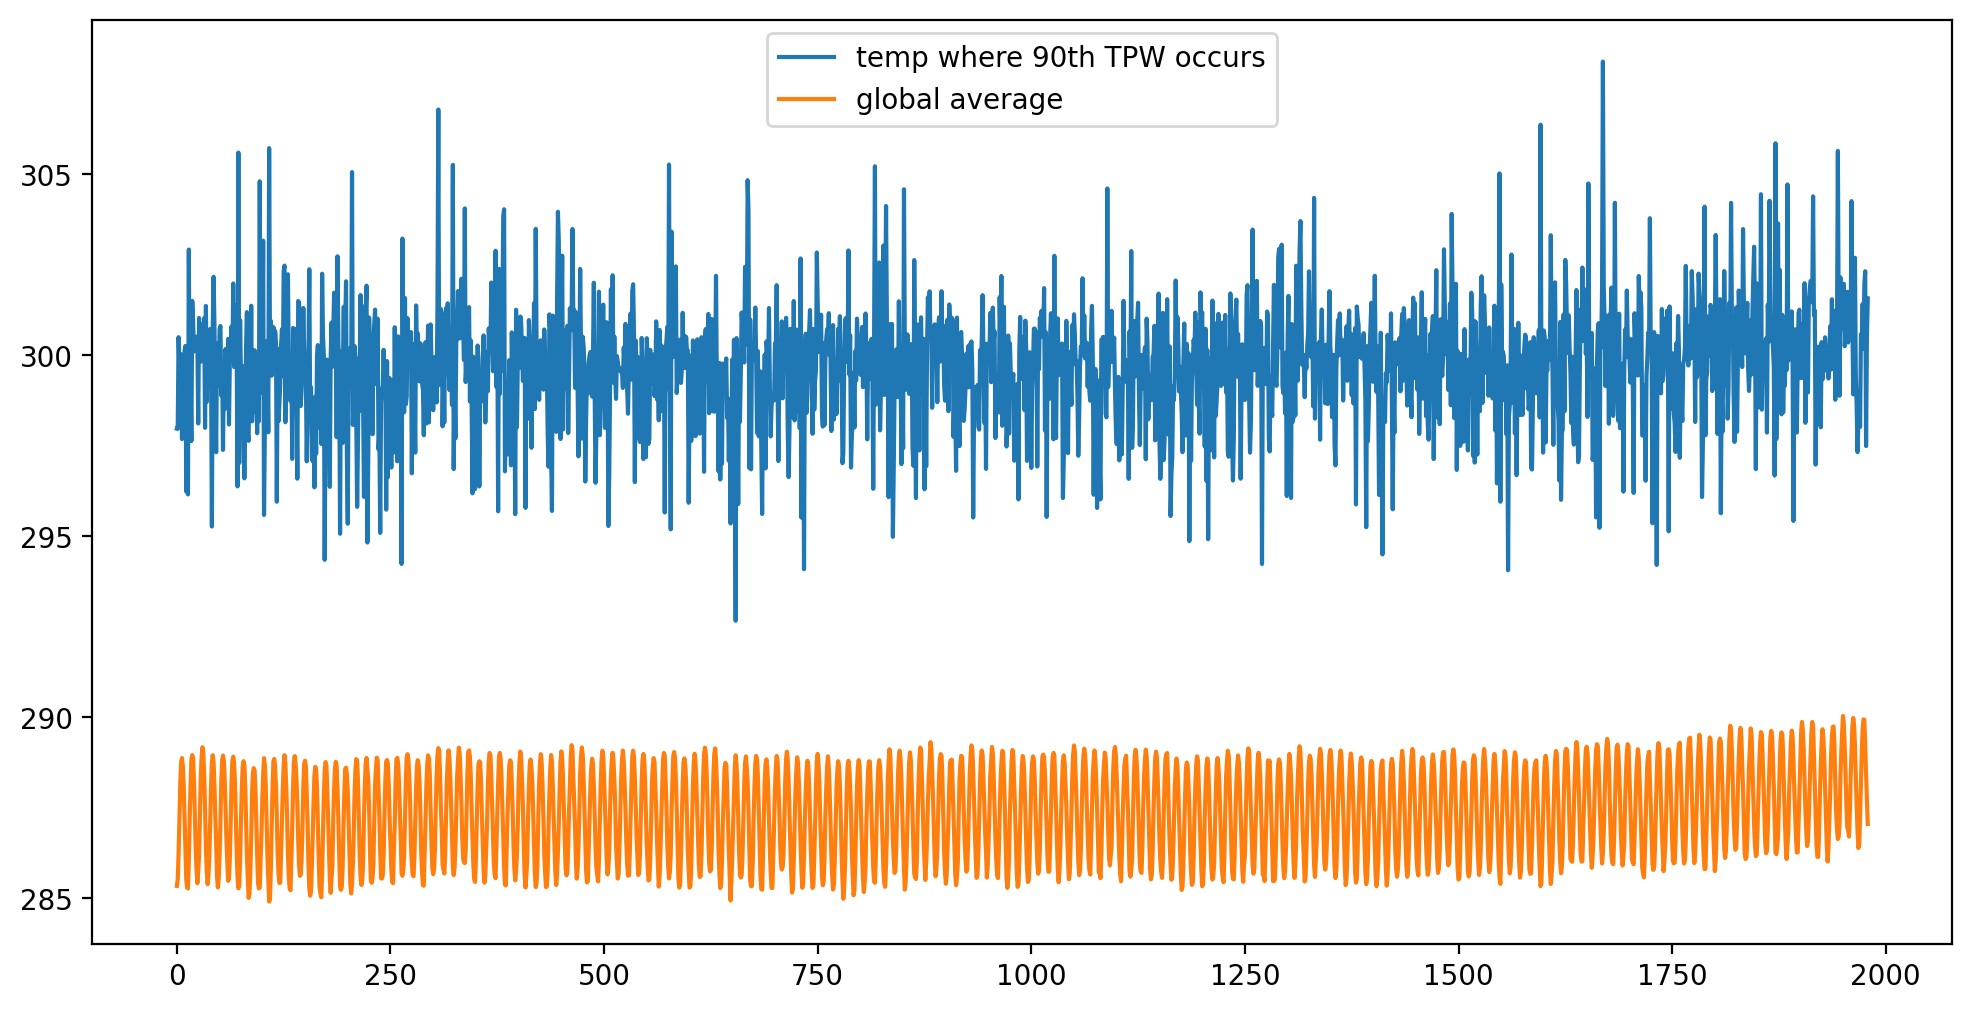

In [37]:
plt.plot(tas_90, label="temp where 90th TPW occurs")
plt.plot(array_tas_ts, label="global average")
plt.legend()
plt.show()

## LINEAR REGRESSION！

beta: 0.004743791185319424


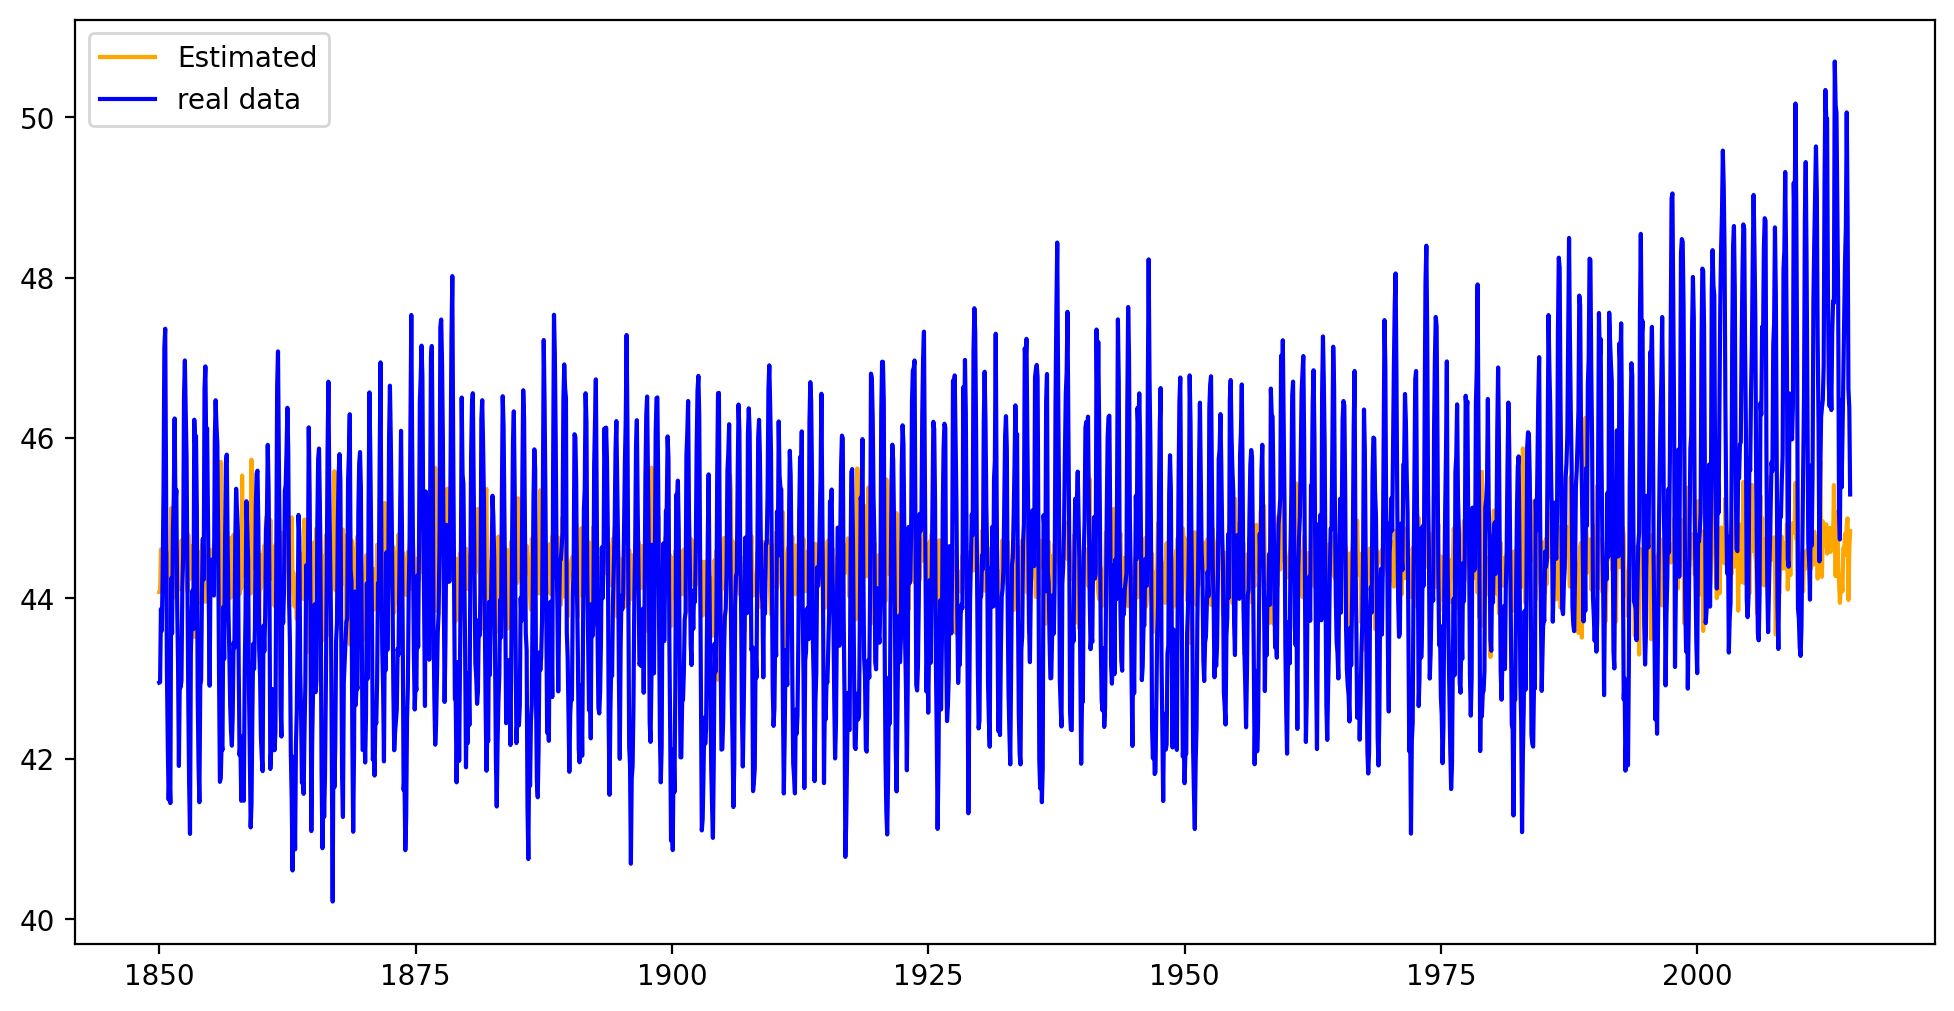

In [30]:
# This is for the 90th percentile prw and the corresponding area's surface temperature
ln_TPW = np.log(array_prw_90)
X_tas_ts = tas_90.reshape(-1, 1)
LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)
beta, alpha = LR_model.coef_[0] , LR_model.intercept_ 
print(f"beta: {beta}")

estimated_TPW_ts = np.exp(alpha + beta * tas_90)
plt.plot(time, estimated_TPW_ts, label="Estimated", color="orange")
plt.plot(time, array_prw_90, label="real data", color="blue")
plt.legend()
plt.show()

beta: 0.02517417073249817


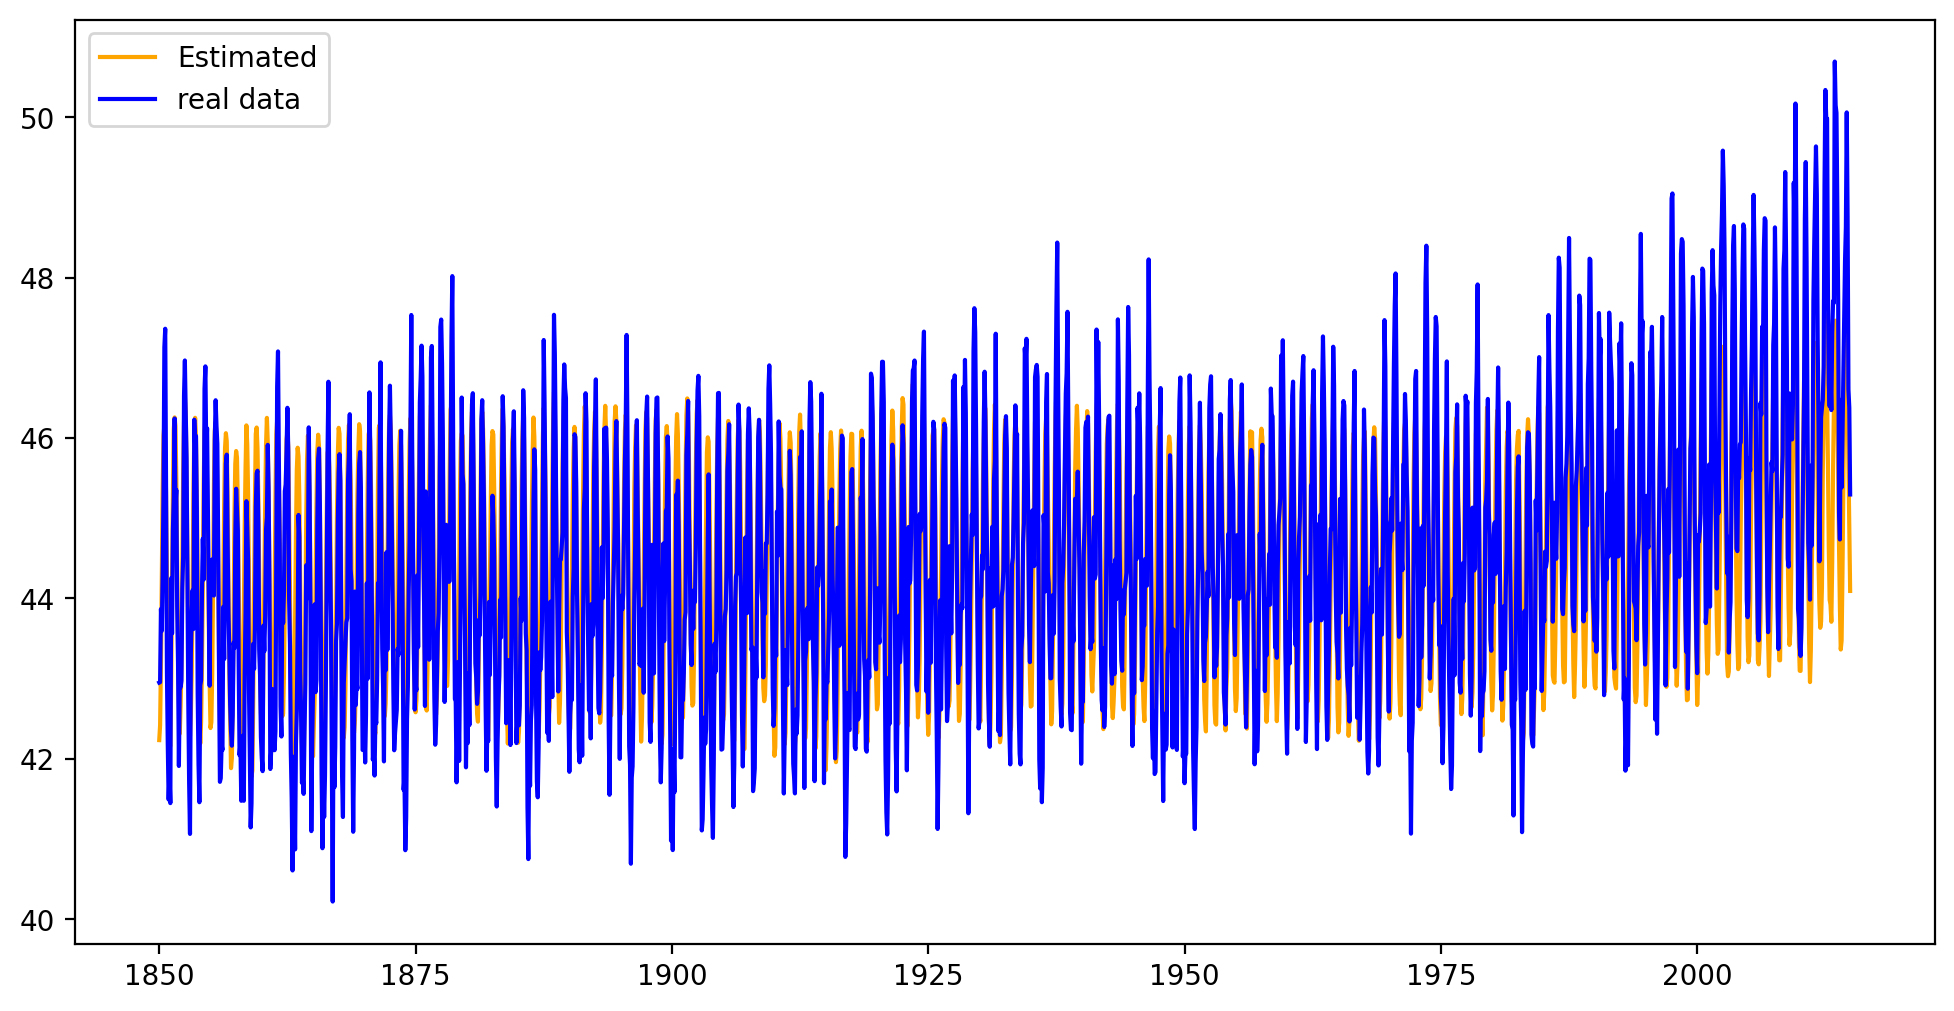

In [38]:
# This is for the 90th percentile prw and the corresponding area's surface temperature
ln_TPW_2 = np.log(array_prw_90)
X_tas_ts_2 = array_tas_ts.reshape(-1, 1)
LR_model_2 = LinearRegression()
LR_model_2.fit(X_tas_ts_2, ln_TPW_2)
beta_2, alpha_2 = LR_model.coef_[0] , LR_model.intercept_ 
print(f"beta: {beta}")

estimated_TPW_ts_2 = np.exp(alpha_2 + beta_2 * array_tas_ts)
plt.plot(time, estimated_TPW_ts_2, label="Estimated", color="orange")
plt.plot(time, array_prw_90, label="real data", color="blue")
plt.legend()
plt.show()

In [19]:
ds_prw_his

<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    prw        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            prw
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/8e2bf5bf-2173-4813-92b0-c53c5589979c...
    version_id:             v20190514